In [79]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim


#Load Inception

In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inception = models.inception_v3(pretrained=True).to(device)
inception.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [81]:
# Function to load and preprocess an image
def load_image(image_path, size=299):
    """Load and preprocess an image."""
    image = Image.open(image_path).convert('RGB')
    in_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return in_transform(image).unsqueeze(0)

def imshow(tensor, title=None, ax=None, figsize=(5, 5)):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    image = tensor.cpu().clone().detach().numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    
    ax.imshow(image)
    if title is not None:
        ax.set_title(title)
    ax.axis('off')


# Function to extract features from specified layers of the model
def get_features_incept(image, model, layers):
    """ Extract features from the layers of the model. """
    features = {}
    x = image
    # Access each layer directly by name and ensure compatible operations
    for name, layer in model.named_children():
        if "AuxLogits" in name:  # Skip auxiliary classifier
            continue
        x = layer(x)
        if name in layers:
            features[name] = x
        if name == 'Mixed_7c':  # Last layer you need features from
            break
    return features


# Function to compute the Gram matrix of a feature map
def gram_matrix(tensor):
    """Compute the Gram matrix from an input tensor."""
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    return torch.mm(tensor, tensor.t())

def content_loss(content_features, target_features):
    return torch.mean((target_features - content_features)**2)


def incept_style_transfer(content_layer, content_image, style_image, target, content_weight, style_weight, style_weights, optimizer, steps, show_every, show_training=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    target = target.to(device)
    content_features = get_features_incept(content_image, inception, [content_layer])  # Assuming `inception` and `get_features_incept` defined elsewhere
    style_features = get_features_incept(style_image, inception, list(style_weights.keys()))

    for ii in range(1, steps + 1):
        optimizer.zero_grad()

        target_features = get_features_incept(target, inception, style_weights.keys())
        content_loss_val = content_loss(content_features[content_layer], target_features[content_layer])

        style_loss_val = 0
        for layer, weight in style_weights.items():
            target_feature = target_features[layer]
            target_gram = gram_matrix(target_feature)
            _, d, h, w = target_feature.shape
            style_gram = gram_matrix(style_features[layer])
            layer_style_loss = weight * torch.mean((target_gram - style_gram) ** 2)
            style_loss_val += layer_style_loss / (d * h * w)

        total_loss = content_weight * content_loss_val + style_weight * style_loss_val
        total_loss.backward(retain_graph=True)
        optimizer.step()

        if show_training and (ii % show_every == 0 or ii == 1):
            print(f'Iteration: {ii}, Total loss: {total_loss.item()}')
            imshow(target)  # Assuming imshow is defined elsewhere
            plt.show()
    return target


In [82]:
def inception_wrap(content_path, style_path, steps,show_every):
    # Define fixed parameters
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    content_layer = 'Mixed_5c'
    content_weight = 1e4
    style_weight = 1e6
    style_layers = {
        'Conv2d_1a_3x3': 0.9, 
        'Conv2d_2a_3x3': 0.7,
        'Conv2d_2b_3x3': 0.2,
        'Mixed_5b': 0.1,
        'Mixed_5c': 0.1
    }
    show_every = show_every
    
    # Prepare the images
    content_image = load_image(content_path,299)
    style_image = load_image(style_path,299)
    content_image = content_image.to(device)
    style_image = style_image.to(device)
    
    # Clone the content image for the target image and make it require gradient
    target = content_image.clone().requires_grad_(True).to(device)

    # Set up the optimizer
    optimizer = optim.Adam([target.requires_grad_()], lr=0.02)
    # Call the original function with all parameters set
    final_image = incept_style_transfer(
        content_layer=content_layer, 
        content_image=content_image, 
        style_image=style_image, 
        target=target, 
        content_weight=content_weight, 
        style_weight=style_weight, 
        style_weights=style_layers, 
        optimizer=optimizer, 
        steps=steps, 
        show_every=show_every
    )

    return final_image



#Load Mobilenet

In [83]:
mobilenet = models.mobilenet_v2(pretrained=True).features
for param in mobilenet.parameters():
    param.requires_grad_(False)
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet.to(device)

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (1): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (

In [84]:
def get_features_mobile(image, model, layers=None):
    if layers is None:
        layers = {
            '0': 'conv1_1',  # Style layer
            '1': 'conv2_1',  # Style layer
            '2': 'conv3_1',  # Style layer
            '3': 'conv4_1',  # Style layer
            '4': 'conv5_1',  # Content layer
            '5': 'conv6_1',  # Style layer
            '6': 'conv7_1',  # Style layer
            '7': 'conv8_1',  # Style layer
            '8': 'conv9_1',  # Style layer
            '9': 'conv10_1',  # Style layer
            '10': 'conv11_1',  # Style layer
            '11': 'conv12_1',  # Style layer
            '12': 'conv13_1',  # Style layer
            '13': 'conv14_1',  # Style layer
            '14': 'conv15_1',  # Style layer
            '15': 'conv16_1',  # Style layer
            '16': 'conv17_1',  # Style layer

        }

    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features


In [85]:
def mobile_style_transfer(content_layer, content_image, style_image, target, content_weight, style_weight, style_weights, optimizer, steps, show_every,show_training= True):
    content_features = get_features_mobile(content_image, mobilenet)
    style_features = get_features_mobile(style_image, mobilenet)
    target_features = get_features_mobile(target, mobilenet)
    
    style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

    # content_layer = 'conv5_1'

    optimizer = optim.Adam([target.requires_grad_()], lr=0.02)

    for ii in range(1, steps + 1):
        target_features = get_features_mobile(target, mobilenet)

        content_loss_val = content_loss(content_features[content_layer], target_features[content_layer])

        style_loss_val = 0

        for layer in style_weights:
            target_feature = target_features[layer]
            target_gram = gram_matrix(target_feature)
            _, d, h, w = target_feature.shape
            style_gram = style_grams[layer]
            layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
            style_loss_val += layer_style_loss / (d * h * w)

        total_loss = content_weight * content_loss_val + style_weight * style_loss_val

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if (ii % show_every == 0 or ii == 1) and show_training:
            print('Iteration:', ii, 'Total loss:', total_loss.item())
            imshow(target)
            plt.show()

    return target


def mobile_wrap(content_path,style_path,steps,show_every):
    # Example usage:
    style_weights = {'conv1_1': 0.9,
                    'conv2_1': 0.7,
                    'conv3_1': 0.5,
                    'conv4_1': 0.2,
                    'conv5_1': 0.2,'conv6_1': 0.1,'conv7_1': 0.1,'conv8_1': 0.1,'conv9_1': 0.1}

    content_weight = 1e2
    style_weight = 1e6
    content_layer = 'conv5_1'
    content_image = load_image(content_path,400).to(device) 
    style_image = load_image(style_path,400).to(device)
    target = content_image.clone().detach()
    target.requires_grad_(True)
    optimizer = optim.Adam([target], lr=0.02)
    steps = steps
    show_every = show_every
    final_image = mobile_style_transfer(content_layer, content_image, style_image, target, content_weight, style_weight, style_weights, optimizer, steps, show_every)
    return final_image



Iteration: 1 Total loss: 2074422.875


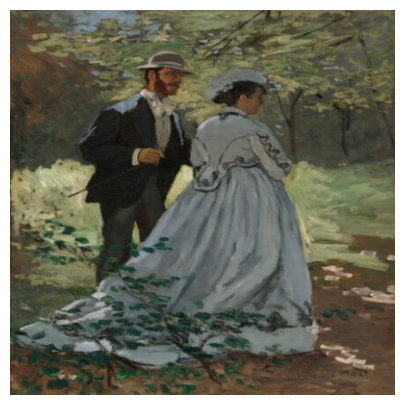

Iteration: 1000 Total loss: 916.7286376953125


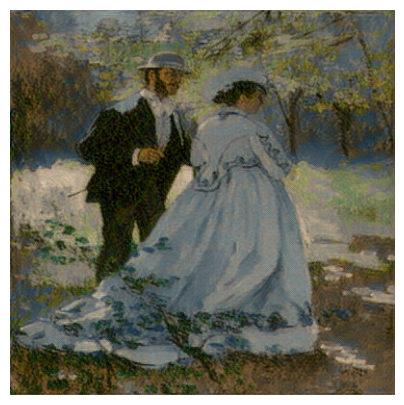

Iteration: 2000 Total loss: 988.853759765625


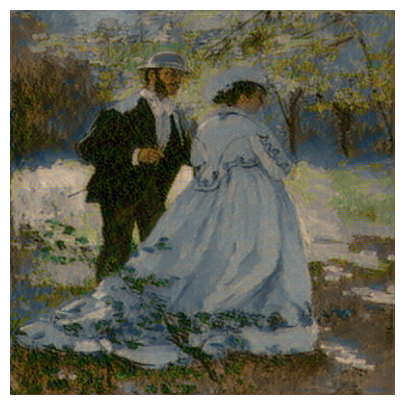

Iteration: 3000 Total loss: 466.33148193359375


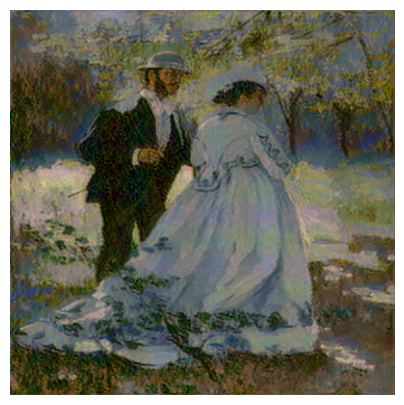

Iteration: 4000 Total loss: 1031.81982421875


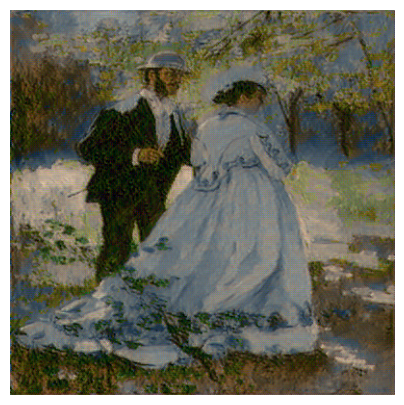

Iteration: 5000 Total loss: 209.44442749023438


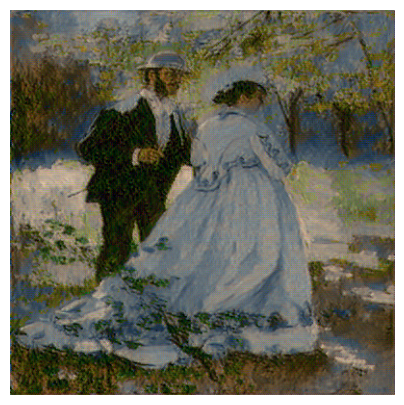

Iteration: 6000 Total loss: 190.17898559570312


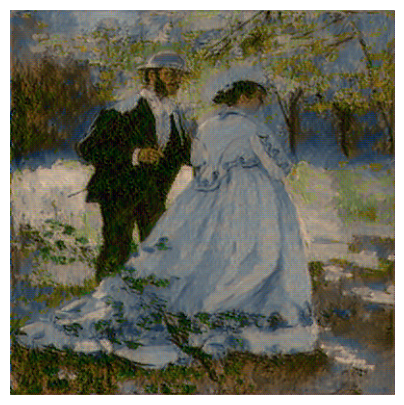

Iteration: 7000 Total loss: 147.42559814453125


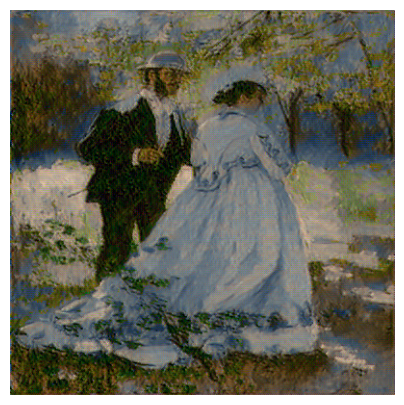

Iteration: 8000 Total loss: 219.50872802734375


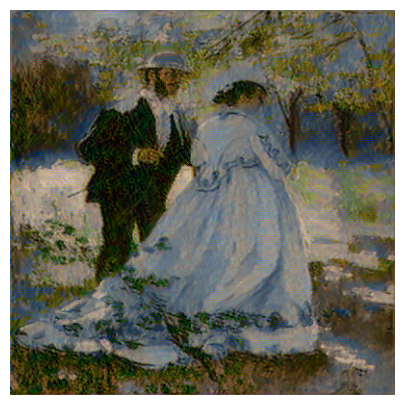

In [86]:
mobile_wrap("content.jpg","style.jpg",8000,1000)


Iteration: 1, Total loss: 573254208.0


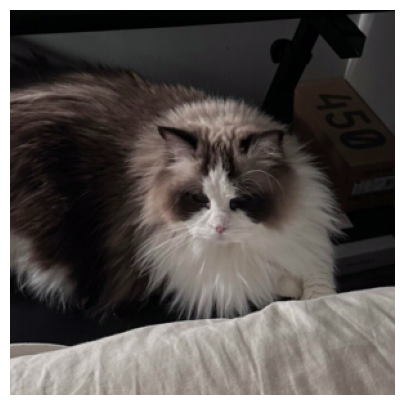

Iteration: 1000, Total loss: 222847.484375


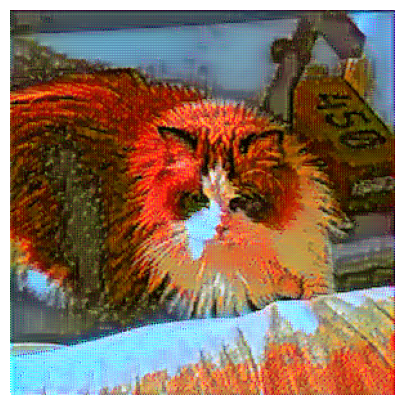

Iteration: 2000, Total loss: 71678.1484375


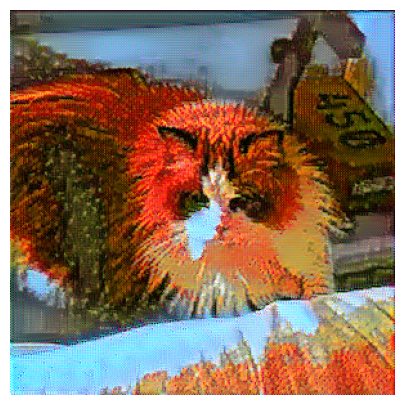

Iteration: 3000, Total loss: 31925.037109375


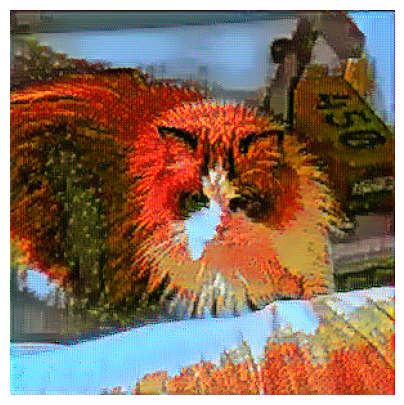

Iteration: 4000, Total loss: 16721.0546875


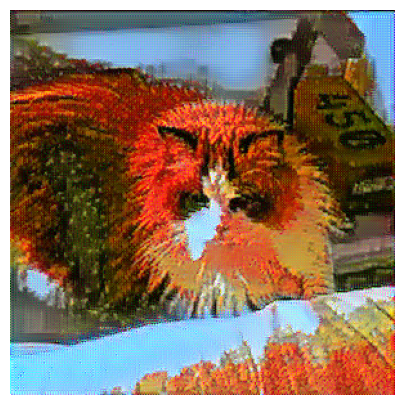

In [87]:
inception_wrap("cat.jpg", "tree.jpg", 4000, 1000)
